**Deep Learning**

**Practice 3.1 - VAE**

**Marcelo Ferrer - Aymen Merchaoui**


## 1. Imports, declarations and configuration

In this section we define the necessary imports, declarations and configuration to run the application. 

In [9]:
# Verify that GPU is active
import tensorflow as tf

gpu_active = tf.config.list_physical_devices('GPU')

if (len(gpu_active) == 0):
    print("NO GPU ACTIVE!!!")
else:
    print("Using GPU")

NO GPU ACTIVE!!!


In [10]:
import numpy as np
import glob, os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [11]:
# Disable eager execution (eager execution executes TensorFlow operations immediately)
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [12]:
# Mat plot workaround
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Load the images

In [13]:
DATA_FOLDER = "dataset/img_align_celeba/"
WEIGHTS_FOLDER = 'dataset/weights/'

if not os.path.exists(WEIGHTS_FOLDER):
    os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
    os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

filenames = np.array(glob.glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 202599


In [14]:
INPUT_DIM = (16,16,3) # Image dimension
BATCH_SIZE = 128 # Size of the batch
Z_DIM = 200 # Dimension of the latent vector (z)

# Normalization from 0 to 1
data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
    target_size = INPUT_DIM[:2],
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = 'input',
    subset = 'training'
    )

Found 202599 images belonging to 1 classes.


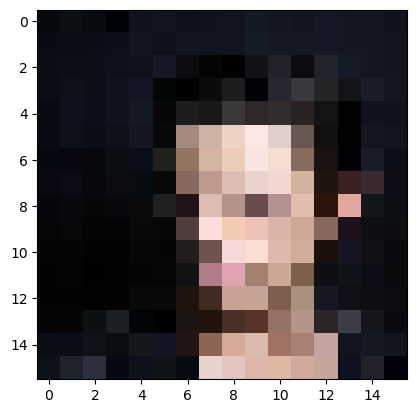

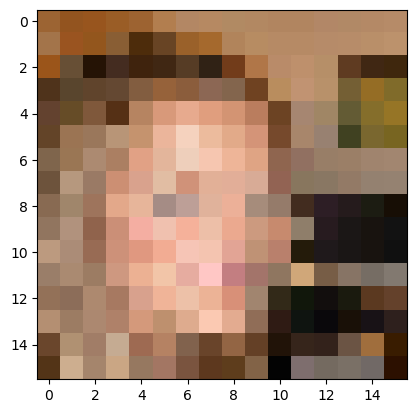

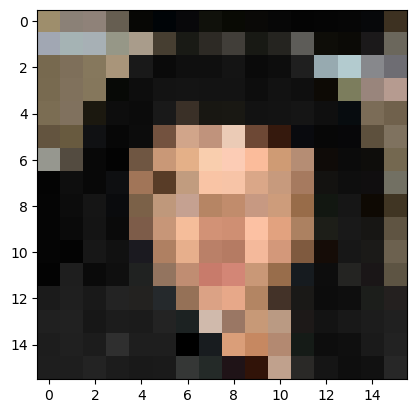

In [15]:
# Show some images to watch
batch = data_flow.next()
for i in range(0,3):
    image = batch[0][i]
    plt.imshow(image)
    plt.show()

In [16]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, conv_strides):
  
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()
    
    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    encoder_input = Input(shape = input_dim, name = 'encoder_input')
    x = encoder_input

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2D(filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'encoder_conv_' + str(i)
            )(x)

        x = LeakyReLU()(x)
        
    # Required for reshaping latent vector while building Decoder
    shape_before_flattening = K.int_shape(x)[1:] 
    
    x = Flatten()(x)
    mean_mu = Dense(output_dim, name = 'mu')(x)
    log_var = Dense(output_dim, name = 'log_var')(x)

    # Defining a function for sampling
    def sampling(args):
        mean_mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon   

    # Using a Keras Lambda Layer to include the sampling function as a layer 
    # in the model
    encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])


    return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)


vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(
    input_dim = INPUT_DIM,
    output_dim = Z_DIM, 
    #conv_filters = [32, 64, 64, 64],
    conv_filters = [16, 32, 32, 32],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2])

vae_encoder.summary()

plot_model(vae_encoder, show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 8, 8, 16)     448         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 8, 8, 16)     0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 4, 4, 32)     4640        ['leaky_re_lu[0][0]']            
                                                                                              

In [17]:
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, conv_strides):

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

    # To get an exact mirror image of the encoder
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2DTranspose(
            filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'decoder_conv_' + str(i)
            )(x)
        
        # Adding a sigmoid layer at the end to restrict the outputs 
        # between 0 and 1
        if i < n_layers - 1:
            x = LeakyReLU()(x)
        else:
            x = Activation('sigmoid')(x)

    # Define model output
    decoder_output = x

    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

decoder_input, decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
    shape_before_flattening = vae_shape_before_flattening,
    #conv_filters = [64,64,32,3],        
    conv_filters = [32,32,16,1],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2]
    )

vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 reshape (Reshape)           (None, 1, 1, 32)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 2, 2, 32)         9248      
 pose)                                                           
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2, 2, 32)          0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 4, 4, 32)         9248      
 pose)                                                     

In [18]:
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae = Model(vae_input, vae_output)

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 8, 8, 16)     448         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 8, 8, 16)     0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 4, 4, 32)     4640        ['leaky_re_lu[0][0]']            
                                                                                            

In [19]:
def plot_compare_VAE(images, add_noise=False):
    
    n_to_show = images.shape[0]

    if add_noise:
        encodings = VAE_encoder.predict(images)
        encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
        reconst_images = VAE_decoder.predict(encodings)

    else:
        reconst_images = vae.predict(images)


    fig = plt.figure(figsize=(12, 3))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.1, wspace=0.1)

    for i in range(n_to_show):
        #img = images[i].squeeze()
        img = images[i]
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img,cmap='gray')

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img,cmap='gray')
    plt.show()

In [20]:
LEARNING_RATE = 0.0005
N_EPOCHS = 2  # No. of epochs to show advance
N_BLOCKS = 10
LOSS_FACTOR = 10000

adam_optimizer = Adam(learning_rate = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)



vae.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])


example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:8]

for i in range(N_BLOCKS):
    vae.fit(data_flow, 
        shuffle=True, 
        epochs = N_EPOCHS, 
        initial_epoch = 0, 
        steps_per_epoch=NUM_IMAGES / BATCH_SIZE)
    plot_compare_VAE(example_images) 

Epoch 1/2
1770/3165 [===============>..............] - ETA: 12:59 - batch: 884.5000 - size: 63.9859 - loss: 460.4430 - r_loss: 0.0431 - kl_loss: 28.9691